In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_color_codes('pastel')

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.datasets import make_classification, make_regression
from sklearn.datasets import load_boston, load_iris, make_moons

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
class IdentityScaler(TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X):
        return X

In [4]:
class PathMachine(BaseEstimator):
    
    def __init__(self, norm=np.linalg.norm, classify=False):
        self.norm = norm
        self.classify = classify
        self.x_scaler = IdentityScaler() if self.classify else StandardScaler()
        self.y_scaler = IdentityScaler() if self.classify else StandardScaler()
        
    def find_start(self, X):
        index_max = None
        value_max = -np.inf
        for index, x in enumerate(X):
            value = self.norm(x)
            if value > value_max:
                index_max = index
                value_max = value
        return index_max
    
    def find_next(self, point, target, X, y):
        index_min = None
        value_min = np.inf
        for index, x in enumerate(X):
            if self.classify and (y[index] != target):
               continue
            value = self.norm(x - point)
            if value < value_min:
                index_min = index
                value_min = value
        return index_min
    
    def fit(self, X, y):
        X = np.copy(X)
        X = self.x_scaler.fit_transform(X)
        
        y = np.copy(y).reshape(-1, 1)
        y = self.y_scaler.fit_transform(y).flatten()
        
        self.paths = {} if self.classify else []
        
        start_index = self.find_start(X)
        start_value = X[start_index]
        start_target = y[start_index]
        
        X = np.delete(X, start_index, axis=0)
        y = np.delete(y, start_index, axis=0)
        
        while len(X) > 0:
            next_index = self.find_next(start_value, start_target, X, y)
            if self.classify and next_index is None:
                start_index = self.find_start(X)
                start_value = X[start_index]
                start_target = y[start_index]
                continue
            next_target = y[next_index]
            
            if self.classify:
                if not next_target in self.paths:
                    self.paths[next_target] = []
                self.paths[next_target].append({
                    'start': start_value,
                    'next': X[next_index]
                })
            else:
                self.paths.append({
                    'start': start_value,
                    'next': X[next_index],
                    'value': start_target,
                    'target': next_target
                })
                
            start_value = X[next_index]
            start_target = y[next_index]
            
            X = np.delete(X, next_index, axis=0)
            y = np.delete(y, next_index, axis=0)
            
        return self
    
    def predict(self, X):
        result = []
        X = self.x_scaler.transform(np.copy(X))
        
        for x in X:
            if self.classify:
                predicted = None
                min_distance = np.inf
                for target in self.paths:
                    for path in self.paths[target]:
                        point = x - path['start']
                        line = path['next'] - path['start']
                        if np.allclose(self.norm(line), 0):
                            continue
                        direction = line / self.norm(line)
                        product = np.dot(point, direction)
                        projection = product * direction
                        
                        distance = self.norm(projection - point)
                        if distance < min_distance:
                            predicted = target
                            min_distance = distance
                result.append(predicted)
            else:
                predicted = None
                min_distance = np.inf
                for path in self.paths:
                    point = x - path['start']
                    line = path['next'] - path['start']
                    if np.allclose(self.norm(line), 0):
                            continue
                    direction = line / self.norm(line)
                    product = np.dot(point, direction)
                    projection = product * direction
                    parameter = np.sign(product) * self.norm(projection) /\
                               self.norm(line)
                    
                    distance = self.norm(projection - point)
                    if distance < min_distance:
                        predicted = (1 - parameter) * path['value'] +\
                                   parameter * path['target']
                        min_distance = distance
                result.append(predicted)
        
        return self.y_scaler.inverse_transform(
            np.array(result).reshape(-1, 1)
        ).flatten()
    
    def score(self, X, y):
        if self.classify:
            return f1_score(y.flatten(), self.predict(X), average='micro')
        else:
            return r2_score(y.flatten(), self.predict(X))

In [5]:
folds = 5
state = 1

In [6]:
iris_data = load_iris()
boston_data = load_boston()

train_cX, test_cX, train_cy, test_cy = train_test_split(
    iris_data.data,
    iris_data.target,
    test_size=0.3,
    random_state=state
)

train_rX, test_rX, train_ry, test_ry = train_test_split(
    boston_data.data,
    boston_data.target,
    test_size=0.3,
    random_state=state
)

In [7]:
squared_norm = lambda vector: np.sqrt(np.sum(vector**2, axis=0))
absolute_norm = lambda vector: np.sum(np.abs(vector))

In [8]:
%%time

c_pred = PathMachine(absolute_norm, classify=True).fit(
    train_cX, train_cy
).predict(test_cX)

r_pred = PathMachine(absolute_norm).fit(
    train_rX, train_ry
).predict(test_rX)

CPU times: user 12.8 s, sys: 96 ms, total: 12.9 s
Wall time: 17.5 s


In [9]:
%%time

r_base = Ridge(random_state=state).fit(
    train_rX, train_ry
).predict(test_rX)

c_base = LogisticRegression(random_state=state).fit(
    train_cX, train_cy
).predict(test_cX)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 452 ms


In [10]:
print("Regression MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_pred),
    r2_score(test_ry, r_pred)
))

print("Base MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_base),
    r2_score(test_ry, r_base)
))

Regression MAE: 2.650, R2: 0.865
Base MAE: 3.287, R2: 0.789


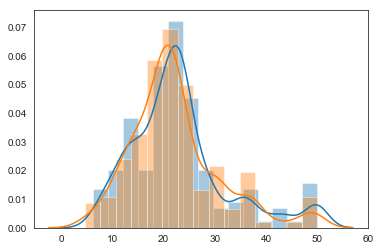

In [11]:
sns.distplot(test_ry);
sns.distplot(r_pred);

In [12]:
print(confusion_matrix(test_cy, c_pred))
print(confusion_matrix(test_cy, c_base))

[[14  0  0]
 [ 0 18  0]
 [ 0  1 12]]
[[14  0  0]
 [ 0 13  5]
 [ 0  0 13]]


In [13]:
print(classification_report(test_cy, c_pred))
print(classification_report(test_cy, c_base))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       0.95      1.00      0.97        18
          2       1.00      0.92      0.96        13

avg / total       0.98      0.98      0.98        45

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      0.72      0.84        18
          2       0.72      1.00      0.84        13

avg / total       0.92      0.89      0.89        45



## Second part
Synthetic datasets with cross-validation.

In [14]:
def check_regressors(X, y, norm=squared_norm):
    for regressor in [
        PathMachine(norm=norm),
        Ridge(random_state=state),
        LinearSVR(random_state=state),
        RandomForestRegressor(random_state=state),
        KNeighborsRegressor()
    ]:
        scores = cross_val_score(
            regressor,
            X=X, y=y,
            cv=KFold(folds)
        )
        
        print(type(regressor).__name__, "%.4f" % scores.mean())

In [15]:
rX, ry = make_regression(
    n_samples=100,
    n_features=10,
    n_informative=5,
    noise=0.,
    random_state=state
)

check_regressors(rX, ry)

PathMachine 0.3677
Ridge 0.9996
LinearSVR 0.6572
RandomForestRegressor 0.5490
KNeighborsRegressor 0.5586


In [16]:
rX, ry = make_regression(
    n_samples=100,
    n_features=3,
    n_informative=2,
    noise=1.,
    random_state=state
)

check_regressors(rX, ry)

PathMachine 0.9624
Ridge 0.9994
LinearSVR 0.9373
RandomForestRegressor 0.8773
KNeighborsRegressor 0.8397


In [17]:
rX, ry = make_regression(
    n_samples=100,
    n_features=1,
    n_informative=1,
    noise=2.,
    random_state=state
)

ry = np.log(1 + ry**2)

check_regressors(rX, ry, norm=lambda vector: np.sqrt(absolute_norm(vector)))

PathMachine 0.9740
Ridge -0.0673
LinearSVR -0.3226
RandomForestRegressor 0.9759
KNeighborsRegressor 0.9738


In [18]:
def check_classifiers(X, y, norm=squared_norm):
    for classifier in [
        PathMachine(norm=norm, classify=True),
        LogisticRegression(random_state=state),
        LinearSVC(random_state=state),
        RandomForestClassifier(random_state=state),
        KNeighborsClassifier()
    ]:
        scores = cross_val_score(
            classifier,
            X=X, y=y,
            scoring=make_scorer(f1_score, average='micro'),
            cv=StratifiedKFold(folds)
        )
        
        print(type(classifier).__name__, "%.4f" % scores.mean())

In [19]:
cX, cy = make_classification(
    n_samples=100,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_classes=5,
    weights=None,
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy)

PathMachine 0.4166
LogisticRegression 0.3187
LinearSVC 0.3187
RandomForestClassifier 0.2176
KNeighborsClassifier 0.3405


In [20]:
cX, cy = make_classification(
    n_samples=100,
    n_features=100,
    n_informative=50,
    n_redundant=50,
    n_classes=2,
    weights=[.1],
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy, norm=absolute_norm)

PathMachine 0.8488
LogisticRegression 0.6086
LinearSVC 0.6496
RandomForestClassifier 0.8604
KNeighborsClassifier 0.8904


In [21]:
cX, cy = make_moons(
    n_samples=100,
    noise=.0,
    random_state=state
)

check_classifiers(cX, cy, norm=absolute_norm)

PathMachine 1.0000
LogisticRegression 0.8500
LinearSVC 0.8600
RandomForestClassifier 0.9800
KNeighborsClassifier 1.0000


## Hidden bonus section
1D-patterns remembering.

In [22]:
weird_norm = lambda vector: absolute_norm(vector) + squared_norm(vector)

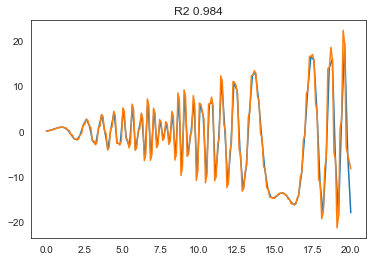

In [23]:
space = np.linspace(0, 20, 100)
X = space.reshape(-1, 1)
y = np.sin(space**2 + 1) * space

prediction = PathMachine(weird_norm).fit(X, y).predict(
    np.linspace(0, 20, 200).reshape(-1, 1)
)

plt.plot(space, y);
plt.plot(np.linspace(0, 20, 200), prediction);
plt.title("R2 %.3f" % r2_score(y, prediction[1::2]));